<ipython-input-6-ef85203bb931>:49: RuntimeWarning: invalid value encountered in divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())


Displaying Grad-CAM for ResNet50 model


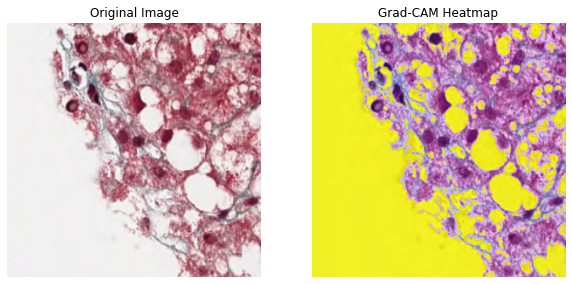

Displaying Grad-CAM for Modified 6,4,1 filter ResNet50 model


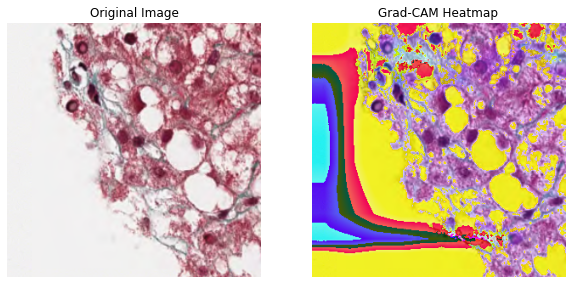

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Load models
#resnet50_model = load_model('D:/PATENT/Model_testing/inflam_model25.h5')
resnet50_model = load_model('D:/PATENT/Model_testing/inflam_model25.h5')
modified_model = load_model('D:/PATENT/Model_testing/inflam_modified25.h5')
#inverted_model = load_model('D:/PATENT/Model_testing/fibrosis_inverted_model25.h5')

# Load training history
#with open('D:/PATENT/Model_testing/inflam_history25.json', 'r') as f:
with open('D:/PATENT/Model_testing/inflam_history25.json', 'r') as f:
    resnet50_history = json.load(f)

with open('D:/PATENT/Model_testing/inflam_modified_history25.json', 'r') as f:
    modified_history = json.load(f)
    
#with open('D:/PATENT/Model_testing/fibrosis_inverted_history25.json', 'r') as f:
#    inverted_history = json.load(f)

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)  # Load image and resize
    x = img_to_array(img)  # Convert to array
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = tf.keras.applications.resnet50.preprocess_input(x)  # Preprocess for ResNet50
    return x

# Grad-CAM function
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Prepare image for Grad-CAM
img_path = "D:/DATASET/CNN/inflammation/test/0/60_322_64.png"
preprocessed_img = preprocess_image(img_path, target_size=(299, 299))

# Generate Grad-CAM for ResNet50 model
heatmap_resnet50 = grad_cam(resnet50_model, preprocessed_img, 'conv5_block3_out')

# Generate Grad-CAM for modified model
heatmap_modified = grad_cam(modified_model, preprocessed_img, 'conv2d_2')

# Generate Grad-CAM for inverted model
#heatmap_inverted = grad_cam(inverted_model, preprocessed_img, 'conv2d_2')

# Generate Grad-CAM for inverted model
#heatmap_inverted = grad_cam(inverted_model, preprocessed_img, 'conv2d_2')

# Visualization function
def display_gradcam(image_path, heatmap):
    img = load_img(image_path)
    img = np.array(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + img

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

# Display Grad-CAM for both models
print("Displaying Grad-CAM for ResNet50 model")
display_gradcam(img_path, heatmap_resnet50)

print("Displaying Grad-CAM for Modified 6,4,1 filter ResNet50 model")
display_gradcam(img_path, heatmap_modified)

#print("Displaying Grad-CAM for Modified inverted filters 1,4,6 ResNet50 model")
#display_gradcam(img_path, heatmap_inverted)


In [ ]:
for layer in resnet50_model.layers:
    print(f"Layer Name: {layer.name}, Output Shape: {layer.output_shape}")

In [ ]:
for layer in modified_model.layers:
    print(f"Layer Name: {layer.name}, Output Shape: {layer.output_shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load models
resnet50_model = load_model('D:/PATENT/Model_testing/resnet50_model10.h5')
modified_model = load_model('D:/PATENT/Model_testing/modified_resnet50_model10.h5')

# Load training history
with open('D:/PATENT/Model_testing/resnet50_history10.json', 'r') as f:
    resnet50_history = json.load(f)

with open('D:/PATENT/Model_testing/modified_resnet50_history10.json', 'r') as f:
    modified_history = json.load(f)

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to get model's intermediate output
def get_intermediate_output(model, img, layer_name):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(img)
    return intermediate_output

# Function to generate a binary mask for collagen-rich areas
def generate_collagen_mask(img, model, layer_name, threshold=0.5):
    # Get the intermediate output (heatmap or feature map)
    intermediate_output = get_intermediate_output(model, img, layer_name)
    
    # Assuming the intermediate output shape is (batch_size, height, width, channels)
    mask = intermediate_output[0, :, :, 0]  # Adjust indexing as necessary based on shape
    
    # Apply threshold to create a binary mask
    binary_mask = mask > threshold
    return binary_mask

# Function to overlay the mask with green color
def overlay_green_mask(original_img, mask):
    green_mask = np.zeros_like(original_img)
    green_mask[:, :, 1] = 255  # Set green channel to max
    
    # Resize mask to match original image size if necessary
    mask_resized = cv2.resize(mask.astype(np.uint8), (original_img.shape[1], original_img.shape[0]))
    
    # Create the overlay
    overlay = cv2.addWeighted(original_img, 0.7, green_mask, 0.3, 0)
    overlay[mask_resized == 0] = original_img[mask_resized == 0]  # Only overlay where mask is 1

    return overlay

# Prepare image for comparison
img_path = 'D:/DATASET/CNN/fibrosis/train/3/368_81_4.png'
original_img = np.array(load_img(img_path))
preprocessed_img = preprocess_image(img_path, target_size=(299, 299))

# Specify the layer names for each model to get the intermediate output
# Choose a layer that outputs feature maps
layer_name_resnet50 = 'conv5_block3_out'
layer_name_modified = 'conv2d_2'  # You might need to change this if the modified model's layer names differ

# Generate collagen masks for both models
collagen_mask_resnet50 = generate_collagen_mask(preprocessed_img, resnet50_model, layer_name_resnet50)
collagen_mask_modified = generate_collagen_mask(preprocessed_img, modified_model, layer_name_modified)

# Overlay green masks on the original image
overlay_resnet50 = overlay_green_mask(original_img, collagen_mask_resnet50)
overlay_modified = overlay_green_mask(original_img, collagen_mask_modified)

# Display the results
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(overlay_resnet50)
plt.title('Collagen Detection with ResNet50')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_modified)
plt.title('Collagen Detection with Modified ResNet50')
plt.axis('off')

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Load models
resnet50_model = load_model('D:/PATENT/Model_testing/resnet50_model10.h5')
modified_model = load_model('D:/PATENT/Model_testing/modified_resnet50_model10.h5')

# Load training history
with open('D:/PATENT/Model_testing/resnet50_history10.json', 'r') as f:
    resnet50_history = json.load(f)

with open('D:/PATENT/Model_testing/modified_resnet50_history10.json', 'r') as f:
    modified_history = json.load(f)

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)  # Load image and resize
    x = img_to_array(img)  # Convert to array
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = tf.keras.applications.resnet50.preprocess_input(x)  # Preprocess for ResNet50
    return x

# Grad-CAM function
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Prepare image for Grad-CAM
img_path = 'D:/DATASET/CNN/fibrosis/train/3/429_56_22.png'
preprocessed_img = preprocess_image(img_path, target_size=(299, 299))

# Generate Grad-CAM for ResNet50 model
heatmap_resnet50 = grad_cam(resnet50_model, preprocessed_img, 'conv5_block3_out')

# Generate Grad-CAM for modified model
heatmap_modified = grad_cam(modified_model, preprocessed_img, 'conv5_block3_out')

# Visualization function
def display_gradcam(image_path, heatmap, colormap=cv2.COLORMAP_JET):
    img = load_img(image_path)
    img = np.array(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + img

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

# Display Grad-CAM for both models with green-dominant colormap
print("Displaying Grad-CAM for ResNet50 model with Summer Colormap")
display_gradcam(img_path, heatmap_resnet50, colormap=cv2.COLORMAP_SUMMER)

print("Displaying Grad-CAM for Modified ResNet50 model with Summer Colormap")
display_gradcam(img_path, heatmap_modified, colormap=cv2.COLORMAP_SUMMER)
